<a href="https://colab.research.google.com/github/yordanovagabriela/neuralnetworks/blob/master/House_Prices_Prediction_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [39]:
!pip install -q -U keras-tuner

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import IPython
import kerastuner as kt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

print(tf.__version__)

2.2.0


# Load Dataset

In [41]:
dataset = pd.read_csv("./kc_house_data.csv")
dataset.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Preprocess Data

## Cleanup columns

In [42]:
del dataset['id']
del dataset['date']
del dataset['zipcode']

## Check For Unknown Values 


In [43]:
dataset.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Drop Duplicate Values

In [44]:
dataset.drop_duplicates(keep = False, inplace = True)

## Split features from labels

In [45]:
X = dataset.drop('price',axis=1)
y = dataset['price']

## Normalize the data

In [46]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(X)

## Split data into train and test

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [48]:
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 17282
Test set size: 4321


# Build Model

In [49]:
def build_model(hidden_units=64, learning_rate=0.001):
  model = keras.Sequential([
    layers.Flatten(input_shape=[len(X_train.keys())]),
    layers.Dense(hidden_units, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(learning_rate)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

model = build_model()

# Train Model

In [50]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=100, es=[]):
  model.fit(X_train,y_train.values,validation_data=(X_val, y_val.values), batch_size=batch_size,epochs=epochs, callbacks=[es])

train_model(model, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, es=es)

Epoch 1/100
271/271 [==============================] - 2s 6ms/step - loss: 378683719680.0000 - mae: 495268.3125 - mse: 378683719680.0000 - val_loss: 329450323968.0000 - val_mae: 453637.7812 - val_mse: 329450323968.0000
Epoch 2/100
271/271 [==============================] - 1s 5ms/step - loss: 314387857408.0000 - mae: 419835.9062 - mse: 314387857408.0000 - val_loss: 278455287808.0000 - val_mae: 393950.3125 - val_mse: 278455287808.0000
Epoch 3/100
271/271 [==============================] - 1s 5ms/step - loss: 263531266048.0000 - mae: 365016.9375 - mse: 263531266048.0000 - val_loss: 221163012096.0000 - val_mae: 328986.1250 - val_mse: 221163012096.0000
Epoch 4/100
271/271 [==============================] - 2s 6ms/step - loss: 194891481088.0000 - mae: 288399.4062 - mse: 194891481088.0000 - val_loss: 152650727424.0000 - val_mae: 246244.9375 - val_mse: 152650727424.0000
Epoch 5/100
271/271 [==============================] - 1s 5ms/step - loss: 125594714112.0000 - mae: 211555.6406 - mse: 12559

# Inspect Loss

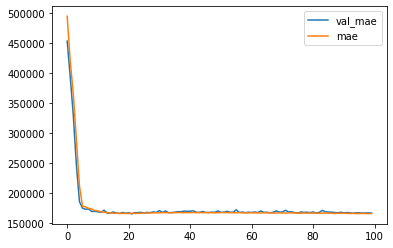

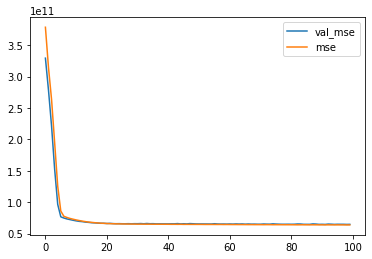

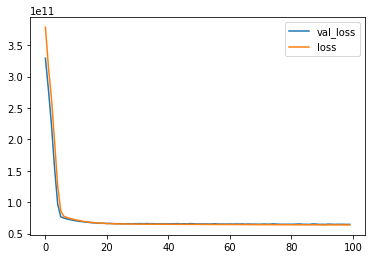

In [51]:
def plot_history(model):
  losses = pd.DataFrame(model.history.history)
  losses[['val_mae', 'mae']].plot()
  losses[['val_mse', 'mse']].plot()
  losses[['val_loss', 'loss']].plot()

plot_history(model)

# Make Predictions

Mean Absolute Error: 166004.09327267992
Mean Square Error: 254506.01359512348


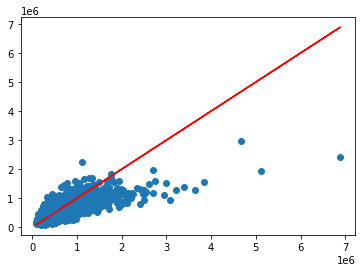

In [52]:
def predict(model, X_test):
  y_preds = model.predict(X_test)

  plt.scatter(y_test, y_preds)
  plt.plot(y_test, y_test, color='red')
  
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_preds))
  print("Mean Square Error:", np.sqrt(mean_squared_error(y_test, y_preds)))


predict(model, X_test)

# Tune Keras Model

In [53]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=[len(X_train.keys())]))
  
  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer 
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = hp_learning_rate),
                loss = 'mse', 
                metrics = ['mse', 'mae'])
  
  return model

In [54]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 300,
                     factor = 3)   

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [55]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [56]:
tuner.search(X_train,y_train.values,validation_data=(X_test,y_test.values), epochs=100, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.01.



In [ ]:
tuned_model = build_model(hidden_units=96, learning_rate=0.01)
train_model(model=tuned_model, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, es=es)
plot_history(tuned_model)
predict(tuned_model, X_test)